In [1]:
#import tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

#group imports
import env
import acquire
import constants_prepare

import json
from typing import Dict, List, Optional, Union, cast
import requests

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

_____________________________________________________________________________

## Exploring Ubuntu:

In [2]:
ubuntu = pd.read_json('ubuntu_data.json')

In [3]:
ubuntu.head()

,repo,language,readme_contents
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...


#### Normalizing the data:

In [4]:
import unicodedata
import re

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [5]:
#to view just one of the readme docs and see what kind of normalizing is needed:
soup = BeautifulSoup(ubuntu.readme_contents.iloc[10], 'html.parser')
soup

Ubuntu 18.04 CIS STIG

[![Build Status](https://travis-ci.com/florianutz/Ubuntu1804-CIS.svg?branch=master)](https://travis-ci.com/florianutz/Ubuntu1804-CIS)
[![Ansible Role](https://img.shields.io/badge/role-florianutz.Ubuntu1804--CIS-blue.svg)](https://galaxy.ansible.com/florianutz/Ubuntu1804-CIS/)

Configure Ubuntu 18.04 machine to be CIS compliant. Level 1 and 2 findings will be corrected by default.

This role **will make changes to the system** that could break things. This is not an auditing tool but rather a remediation tool to be used after an audit has been conducted.

## IMPORTANT INSTALL STEP

If you want to install this via the `ansible-galaxy` command you'll need to run it like this:

`ansible-galaxy install -p roles -r requirements.yml`

With this in the file requirements.yml:

```
- src: https://github.com/florianutz/Ubuntu1804-CIS.git
```

Based on [CIS Ubuntu Benchmark v2.0.1 - 01-03-2020 ](https://www.cisecurity.org/cis-benchmarks/).

This repo originated from work do

In [6]:
#getting an overall view of the data:
ubuntu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1100 non-null   object
 1   language         964 non-null    object
 2   readme_contents  1100 non-null   object
dtypes: object(3)
memory usage: 25.9+ KB


In [7]:
#looking at any nulls:
ubuntu.isnull().sum()

repo                 0
language           136
readme_contents      0
dtype: int64

In [8]:
#dropping nulls (we found that these repos have no languages attached)
ubuntu = ubuntu.dropna()

In [9]:
#df w/o nulls:
ubuntu.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [10]:
#seeing the unique languages:
ubuntu.language.value_counts()

Shell               502
Python              105
Dockerfile           51
C                    44
C++                  34
HTML                 33
Ruby                 27
JavaScript           24
Jinja                18
Go                   12
PHP                  12
CSS                  11
Makefile             11
Puppet               10
HCL                   9
Jupyter Notebook      8
Vim script            6
Dart                  6
PowerShell            4
QML                   4
Nginx                 3
Perl                  3
Objective-C           3
Scheme                2
C#                    2
TeX                   2
SCSS                  2
Haskell               2
R                     2
M4                    1
YAML                  1
Rich Text Format      1
Vue                   1
Java                  1
Scala                 1
Smarty                1
Groovy                1
VimL                  1
Emacs Lisp            1
Tcl                   1
Batchfile             1
Name: language, 

______________________________________________

## Ubuntu Languages:

In [11]:
#looking at the overall percentages of the top 10 languages used in Ubuntu repos:
language_counts=ubuntu.language.value_counts(normalize=True).head(10)
language_counts

Shell         0.520747
Python        0.108921
Dockerfile    0.052905
C             0.045643
C++           0.035270
HTML          0.034232
Ruby          0.028008
JavaScript    0.024896
Jinja         0.018672
Go            0.012448
Name: language, dtype: float64

In [12]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : language_counts.index, 'percentage': language_counts.values})
temp

,language,percentage
0,Shell,0.520747
1,Python,0.108921
2,Dockerfile,0.052905
3,C,0.045643
4,C++,0.035270
5,HTML,0.034232
6,Ruby,0.028008
7,JavaScript,0.024896
8,Jinja,0.018672
9,Go,0.012448


<AxesSubplot:xlabel='language', ylabel='percentage'>

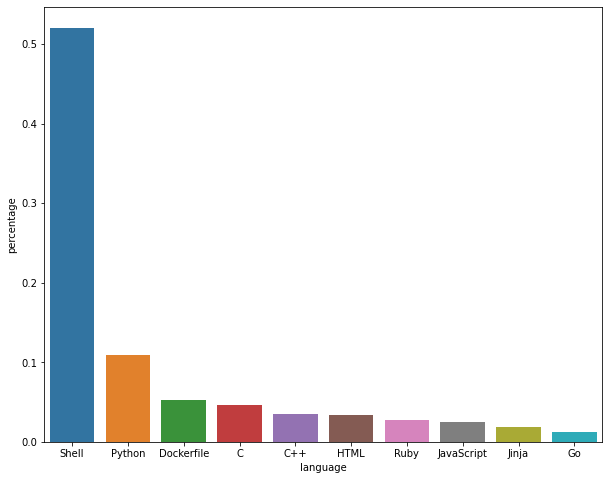

In [13]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')

## Cleaning the Data:

Steps to parsing data:
- 1) Convert text to all lower case for normalcy.
- 2) Remove any accented characters, non-ASCII characters.
- 3) Remove special characters and html and linux related words.
- 4) Stem or lemmatize the words.(stem = "if b, then c")
- 5) Remove stopwords.(if, and, the, etc)
- 6) Store the clean text and the original text for use in future notebooks.

In [14]:
ADDITIONAL_STOPWORDS = [
    'sudo',
    'distro',
    'linux',
    'aptget',
    'ubuntu',
    'debian',
    'arch',
    'archlinux',
    'git',
    'root',
    'image',
    'install',
    'installed',
    'installing',
    'use', 
    'user',
    'used',
    'using',
    'server',
    'kernel',
    'update',
    'package', 
    'file',
    'run', 
    'system', 
    'configure',
    'configured',
    'command',
    'script', 
    'set', 
    'build',
    'need',
    'make',
    'option',
    'contain',
    'contained',
    1,
    'server',
    'update',
    'updated',
    'kerneled',
    'version',
    '1',
    'download',
    'create', 
    'default'
    
] 

def clean_data(text):
    ps = nltk.porter.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[\(<\"]?http.*[\)>\"\s]', ' ', text).split()
    words = [re.sub(r'[^\w\s]', '', text) for text in words]
    try:
        while True:
            words.remove('')
    except ValueError:
        pass
    
    return ' '.join([ps.stem(word) for word in words if word not in stopwords])

In [15]:
#grabbing text from df:
ubuntu_corpus = ' '.join(ubuntu['readme_contents'])
ubuntu_corpus[:100]

'## Ubuntu Dockerfile\n\n\nThis repository contains **Dockerfile** of [Ubuntu](http://www.ubuntu.com/) f'

In [16]:
#creating a list 
ubuntu_corpus_list = clean_data(ubuntu_corpus).split()
ubuntu_corpus_list

['dockerfil',
 'repositori',
 'contain',
 'dockerfil',
 'base',
 'docker',
 'ubuntu1404',
 'instal',
 'docker',
 '2',
 'autom',
 'altern',
 'dockerfil',
 'docker',
 'tdockerfileubuntu',
 'githubcomdockerfileubuntu',
 'usag',
 'docker',
 'rm',
 'dockerfileubuntu',
 'packer',
 'templat',
 'written',
 'legaci',
 'json',
 'overview',
 'repositori',
 'contain',
 'packer',
 'current',
 'box',
 'longer',
 'provid',
 'prebuilt',
 'binari',
 'templat',
 'build',
 'vagrant',
 'box',
 'packer',
 'box',
 'virtualbox',
 'vmware',
 'fusion',
 'parallel',
 'parallel',
 'requir',
 'parallel',
 'virtual',
 'sdk',
 'mac',
 'addit',
 'prerequisit',
 'json',
 'file',
 'contain',
 'variabl',
 'specif',
 'version',
 'tell',
 'packer',
 'specif',
 'variabl',
 'via',
 'varfil',
 'line',
 'overrid',
 'option',
 'core',
 'ubuntujson',
 'packer',
 'templat',
 'build',
 '2004',
 'exampl',
 '2004',
 'follow',
 'packer',
 'varfileubuntu2004json',
 'ubuntujson',
 'want',
 'box',
 'specif',
 'desktop',
 'virtual',
 '

In [17]:
u_count = pd.Series(ubuntu_corpus_list)

In [18]:
u_count.value_counts().nlargest(20)

docker      1763
bash        1473
instal      1316
e           1283
de          1246
contain     1129
ensur       1107
work        1102
follow      1067
chang       1052
2           1031
autom       1029
support      998
configur     956
start        952
test         943
file         931
run          930
name         901
gener        893
dtype: int64

In [19]:
#adding the clean function through the readme content and adding 
#onto a new column in the df:
ubuntu['clean_readme'] = ubuntu.readme_contents.apply(clean_data)
ubuntu

,repo,language,readme_contents,clean_readme
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,dockerfil repositori contain dockerfil base do...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,packer templat written legaci json overview re...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,deepin wine deepinwin ubuntudebian deepin gite...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,dockerubuntuvncdesktop docker pull docker star...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,docker i386 buildimagesh docker 32bitubuntu160...
...,...,...,...,...
1095,kurniawandata/nasihosting,PHP,# nasihosting\n\nNasihosting v5.2\n-----------...,nasihost nasihost v52 alt text untuk mendukung...
1096,mastermindg/trac-docker-ubuntu,Shell,# trac-ubuntu\n\n[![](https://images.microbadg...,tracubuntu docker hub repo build docker contai...
1097,hortonworks/docker-protractor,Shell,**General Docker image for executing headless ...,gener docker execut headless googl chrome fire...
1098,rubiojr/surface3-kernel,C,Linux kernel release 3.x <http://kerne...,releas 3x releas note 3 read care tell explain...


______________________________

## Creating a df for the top 10 languages:

In [20]:
#finding all shell readmes:
shell_readme =' '.join(ubuntu[ubuntu['language'] == 'Shell'].clean_readme)

In [21]:
ubuntu[ubuntu['language'] == 'Shell'].clean_readme

0       dockerfil repositori contain dockerfil base do...
1       packer templat written legaci json overview re...
4       docker i386 buildimagesh docker 32bitubuntu160...
6       termuxubuntu chroot termux wget proot termux p...
8       shadowsock auto shadowsock shadowsockssh auto ...
                              ...                        
1091    debianubuntu loung href altbuild statu src rep...
1093    minecraftinitscript jami bainbridg jamiebainbr...
1094    wsl dotfil simpl dotfil script setup _window s...
1096    tracubuntu docker hub repo build docker contai...
1097    gener docker execut headless googl chrome fire...
Name: clean_readme, Length: 502, dtype: object

In [22]:
#renaming to shell words and cleaning data:
shell_words=clean_data(shell_readme)

In [23]:
#finding all python readmes:
python_readme =' '.join(ubuntu[ubuntu['language'] == 'Python'].clean_readme)

In [24]:
#renaming to python words and cleaning data:
python_words=clean_data(python_readme)

In [25]:
#finding all dockerfile readmes:
dockerfile_readme =' '.join(ubuntu[ubuntu['language'] == 'Dockerfile'].clean_readme)

In [26]:
#renaming to dockerfile words and cleaning data:
dockerfile_words=clean_data(dockerfile_readme)

In [27]:
#finding all C readmes:
C_readme =' '.join(ubuntu[ubuntu['language'] == 'C'].clean_readme)

In [28]:
#renaming to C words and cleaning data:
C_words=clean_data(C_readme)

In [29]:
#finding all C ++ readmes:
Cplus_readme =' '.join(ubuntu[ubuntu['language'] == 'C++'].clean_readme)

In [30]:
#renaming to C++ words and cleaning data:
Cplus_words=clean_data(Cplus_readme)

### Finding word frequencies per language:

In [31]:
#creating series with frequencies by putting the clean_readme strings
#as series (but use split to split up words into a list)

shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
dockerfile_freq = pd.Series(dockerfile_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
Cplus_freq = pd.Series(Cplus_words.split()).value_counts()

In [32]:
#looking at how we need to split:
pd.Series(shell_words.split()).value_counts()

de               1227
e                1059
bash              794
video             773
instal            734
                 ... 
xlm                 1
tether              1
usdt                1
bch                 1
ubuntuservers       1
Length: 22346, dtype: int64

In [33]:
#combining frequencies into dataframes:
word_counts = (pd.concat([shell_freq, python_freq, dockerfile_freq, C_freq, Cplus_freq], axis=1, sort=True)
              .set_axis(['shell','python','dockerfile','C','Cplus'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [34]:
word_counts.head()

,shell,python,dockerfile,C,Cplus
0,206,66,10,5,28
00,2,0,0,0,2
000,0,1,0,0,0
0000,5,0,1,0,0
00000,2,0,0,0,0


### What are the most occuring words across these languages?

In [35]:
word_counts.sort_values(by='shell', ascending=False).head(10)

,shell,python,dockerfile,C,Cplus
de,1227,2,0,0,4
e,1059,25,39,2,5
bash,794,96,67,32,23
video,773,2,3,5,1
instal,734,106,14,51,30
docker,671,82,471,11,0
work,577,137,45,38,47
follow,514,115,82,23,46
lt,498,16,28,9,23
link,467,24,14,7,5


___________________________________

## How long is a typical Ubuntu Readme (after clean)?

In [36]:
#creating a column that gives the lenght of the readme_contents after clean_data function
ubuntu['length_of_readme'] = ubuntu['readme_contents'].apply(lambda r : len(clean_data(r)))

<AxesSubplot:>

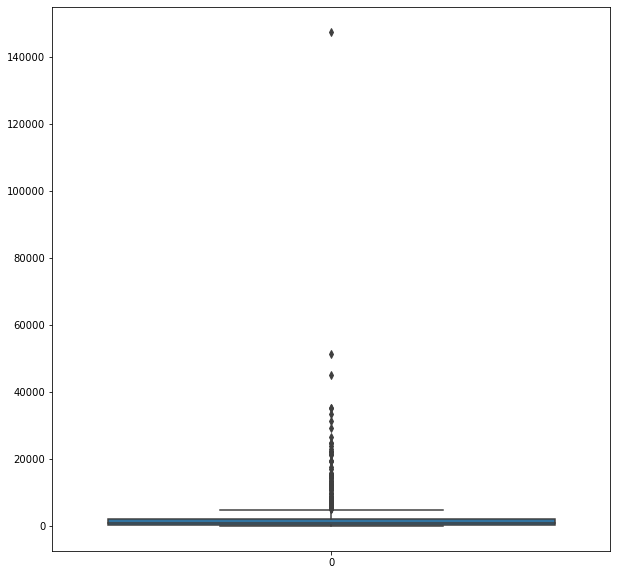

In [37]:
#plotting this to show any anomalies:
plt.figure(figsize = (10,10))
sns.boxplot(data = ubuntu.length_of_readme)

In [38]:
#finding the mean, min and max of Ubuntu readmes:
ubuntu.length_of_readme.describe()

count       964.00000
mean       2532.25000
std        6611.96954
min           0.00000
25%         350.50000
50%        1006.00000
75%        2239.00000
max      147543.00000
Name: length_of_readme, dtype: float64

In [39]:
#longest readme info:
ubuntu[ubuntu['length_of_readme'] == 147543]

,repo,language,readme_contents,clean_readme,length_of_readme
1062,shaohua0116/ICLR2020-OpenReviewData,Jupyter Notebook,# Crawl and Visualize ICLR 2020 OpenReview Dat...,crawl visual iclr 2020 openreview data p align...,147543


In [40]:
#minimum readmes:
ubuntu[ubuntu['length_of_readme'] == 0]

,repo,language,readme_contents,clean_readme,length_of_readme
35,ErickWendel/ew-ubuntu-setup,Shell,,,0
74,officialputuid/UbuntuSSH,Shell,,,0
135,ErickWendel/ew-ubuntu-setup,Shell,,,0
174,officialputuid/UbuntuSSH,Shell,,,0
263,till/ubuntu,Shell,,,0
284,Sushrut1101/Ubuntu-Tmate,Shell,,,0
303,sandheepgr/ubuntu-customization,Shell,,,0
454,umangv/indicator-stickynotes,Python,,,0
621,lxc/lxc-pkg-ubuntu,C,,,0
735,ubuntu-mate/ubuntu-mate-artwork,Shell,,,0


In [41]:
ubuntu['cleaned_length'] = 0

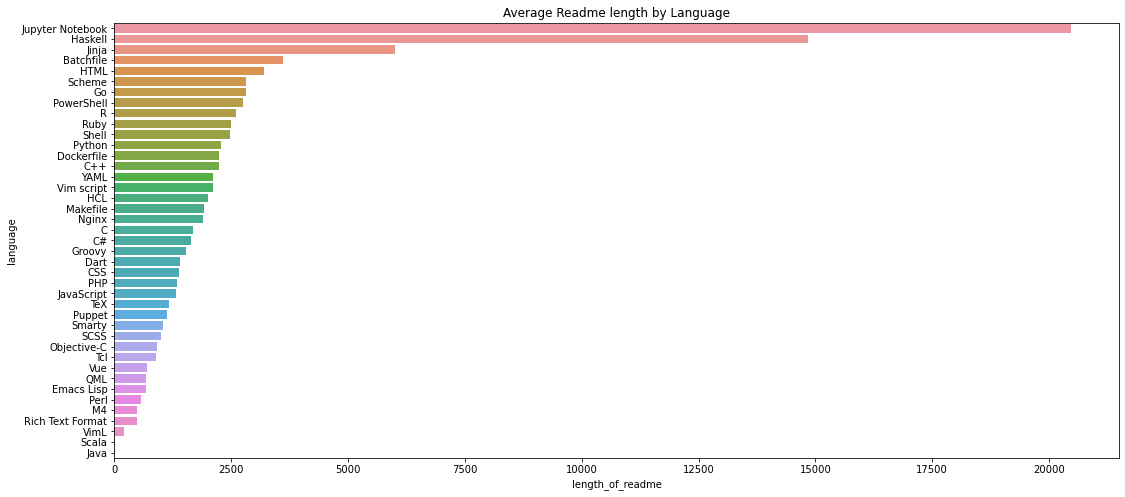

In [44]:
plt.figure(figsize=(18, 8))
sns.barplot(data = ubuntu.groupby('language').mean().reset_index().sort_values('length_of_readme', ascending=False), x = 'length_of_readme', y='language')
plt.title('Average Readme length by Language')
plt.show()

_____________________________________________

## Number of unique words in Ubuntu Repos:

In [ ]:
ubuntu_corpus_series = pd.Series(ubuntu_corpus_list)
pd.Series(ubuntu_corpus_list).nunique()

___________________________________________

## Most common bigrams of Ubuntu:

In [ ]:
ubuntu_bigrams = (pd.Series(nltk.ngrams(ubuntu_corpus_series, 2)).value_counts().head(20))

In [ ]:
ubuntu_bigrams

## Most common trigrams of Ubuntu:

In [ ]:
ubuntu_trigrams = (pd.Series(nltk.ngrams(ubuntu_corpus_series, 3)).value_counts().head(20))
ubuntu_trigrams